In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr

In [2]:
import xesmf as xe
import importlib
importlib.reload(xe)

<module 'xesmf' from '/Users/zhuangjw/Research/Computing/ESMPy-xarray/xESMF/xesmf/__init__.py'>

# build regridder

In [3]:
ds_in = xe.util.grid_global(1.5, 1.5)
ds_out = xe.util.grid_global(1.0, 1.0)
ds_out

<xarray.Dataset>
Dimensions:  (x: 360, x_b: 361, y: 180, y_b: 181)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 -89.5 ...
    lon_b    (y_b, x_b) float64 -180.0 -179.0 -178.0 -177.0 -176.0 -175.0 ...
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 -90.0 -90.0 -90.0 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

In [5]:
regridder = xe.Regridder(ds_in, ds_out, 'bilinear')

In [6]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
(Nlat_in, Nlon_in):         (120, 240) 
(Nlat_out, Nlon_out):       (180, 360) 
Weight filename:            bilinear_120x240_180x360.nc 

# Regrid 2D data

In [8]:
ds_in['data'] = xe.data.wave_sharp(ds_in['lon'], ds_in['lat'])

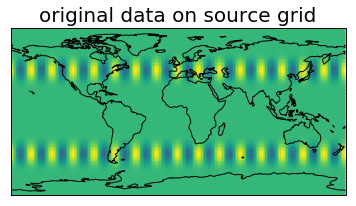

In [9]:
def plot_datafield(ax, ds, data):
    ax.pcolormesh(ds['lon_b'], ds['lat_b'], data,
                  vmin=0, vmax=3)
    ax.coastlines()

fig = plt.figure(figsize=[6, 4])
ax = plt.axes(projection=ccrs.PlateCarree())

plot_datafield(ax, ds_in, ds_in['data'])
ax.set_global()
ax.set_title('original data on source grid', fontsize=20)

In [10]:
outdata = regridder(ds_in['data'])

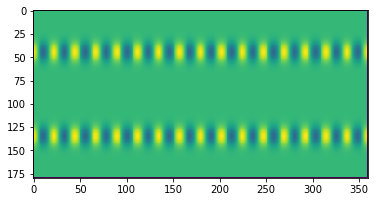

In [11]:
plt.imshow(outdata, vmax=3, vmin=0)

# Broadcast

In [12]:
extra_dims = [50, 10] # lev, time
ds_in.coords['time'] = np.arange(1, extra_dims[1]+1)
ds_in.coords['lev'] = np.arange(1, extra_dims[0]+1)
ds_in['data4D'] = ds_in['time'] * ds_in['lev'] * ds_in['data']

In [13]:
ds_in['data4D'].shape

(10, 50, 120, 240)

In [14]:
%time outdata4D = regridder(ds_in['data4D'])

CPU times: user 227 ms, sys: 89 ms, total: 316 ms
Wall time: 317 ms


In [15]:
outdata4D.shape

(10, 50, 180, 360)

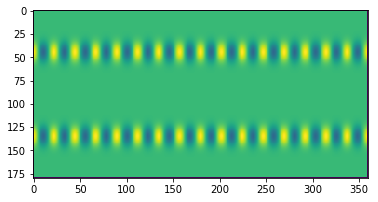

In [16]:
plt.imshow(outdata4D[0,0,:,:])

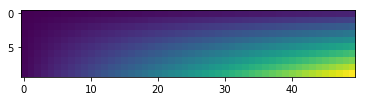

In [17]:
plt.imshow(outdata4D[:,:,10,10])